In [370]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import openpyxl
import math

In [371]:
database = r".\MT.xlsx"

# Área dos formigueiros

Realizar a leitura da base de dados

In [372]:
dataset_initial = pd.read_excel(database)

Separar a base de dados, deixando apens os campos que serão utilizados.  
Remover pontos de GPS sem ninhos.  
Remover linhas com valores vazios.

In [373]:
dataset = dataset_initial[['VL_LARG','VL_COMP','ID_CONDI','ID_ESPECIE','VL_OAD']]
dataset = dataset.loc[dataset['ID_CONDI'] != 0]
dataset = dataset.dropna()

Define o grupo de formiga com base na espécie.

In [374]:
especie_grupo = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:1,
    5:1,
    6:2
}

def escolhe_grupo(especie:int):
    '''
    # Método Escolhe Grupo
    Retorna o código do grupo de formiga.

    ::

        especie[int] -> return int
    '''
    return especie_grupo[especie]

In [375]:
dataset['ID_GRUPO'] = dataset['ID_ESPECIE'].apply(lambda x: escolhe_grupo(x))

Retorna os valores distintos dos grupos.

In [376]:
unique_grupo = dataset['ID_GRUPO'].unique()

In [377]:
unique_grupo.sort()

In [378]:
nome_grupo = {
    1:'Saúva',
    2:'Quenquem',
    3:'Olheiro alimentação',
}

Cria o campo de tamanho em m² do ninho.

In [379]:
dataset = dataset.assign(VL_AREA_F = dataset['VL_LARG'] * dataset['VL_COMP'])

In [380]:
for row in dataset.itertuples():
    if(row[5]) == 0:
        dataset.at[row.Index, "VL_COMP_2"] = dataset.at[row.Index, "VL_COMP"]

    if( (row[5] > 0) and (row[7] < 1) ):
        dataset.at[row.Index, "VL_COMP_2"] = (1 + dataset.at[row.Index, "VL_OAD"]) / dataset.at[row.Index, "VL_LARG"]

    if( (row[5] > 0) and (row[7] >= 1) ):
        dataset.at[row.Index, "VL_COMP_2"] = (dataset.at[row.Index, "VL_AREA_F"] + dataset.at[row.Index, "VL_OAD"]) / dataset.at[row.Index, "VL_LARG"]

In [381]:
unique_grupo

array([1, 2, 3], dtype=int64)

In [382]:
num_charts = len(unique_grupo)

In [383]:
# dataset.sort_values(by='VL_LARG',axis=0)

Realiza o calculo para determinar quanto desproporcional o ninho se encontra.

In [384]:
dataset = dataset.assign(DISTANCE_CENTROID = 0)

In [385]:
for row in dataset.itertuples():
        dataset.at[row.Index, "DISTANCE_FROM_INITIAL_POINT"] = math.dist([1,1], [row[1], row[2]])

In [386]:
#dataset.sort_values('DISTANCE_FROM_INITIAL_POINT', ascending=False)

Plota os gráficos para todos os grupos.

In [387]:
def calculateCentroid(xList, yList, coordinates):
    xCenter = np.sum(xList)/len(xList)
    yCenter = np.sum(yList)/len(yList)

    coordinates.append(xCenter)
    coordinates.append(yCenter)
    
    return coordinates

In [388]:
for index, grupo in enumerate(unique_grupo):

    dataset_filter = dataset.loc[dataset['ID_GRUPO'] == grupo]
    
    coordinatesCenter = []

    if int(grupo) == 3: 
        coordinatesCenter = [1,1]
    else: 
        calculateCentroid(dataset_filter['VL_LARG'], dataset_filter['VL_COMP_2'], coordinatesCenter)

    
    for row in dataset_filter.itertuples():
        if( (row[1] * row[2] > 10) & (row[5] < 1) ):
            dataset.at[row.Index, "DISTANCE_CENTROID"] = ( math.dist(coordinatesCenter, [row[1], row[8]]) - row[5] ) * 2
        else:
            dataset.at[row.Index, "DISTANCE_CENTROID"] = ( math.dist(coordinatesCenter, [row[1], row[8]])  )


    print(f"Centroid para {nome_grupo[grupo]} -> {coordinatesCenter}")

Centroid para Saúva -> [2.634188034188034, 3.580692543787782]
Centroid para Quenquem -> [0.5763636363636363, 0.7400000000000001]
Centroid para Olheiro alimentação -> [1, 1]


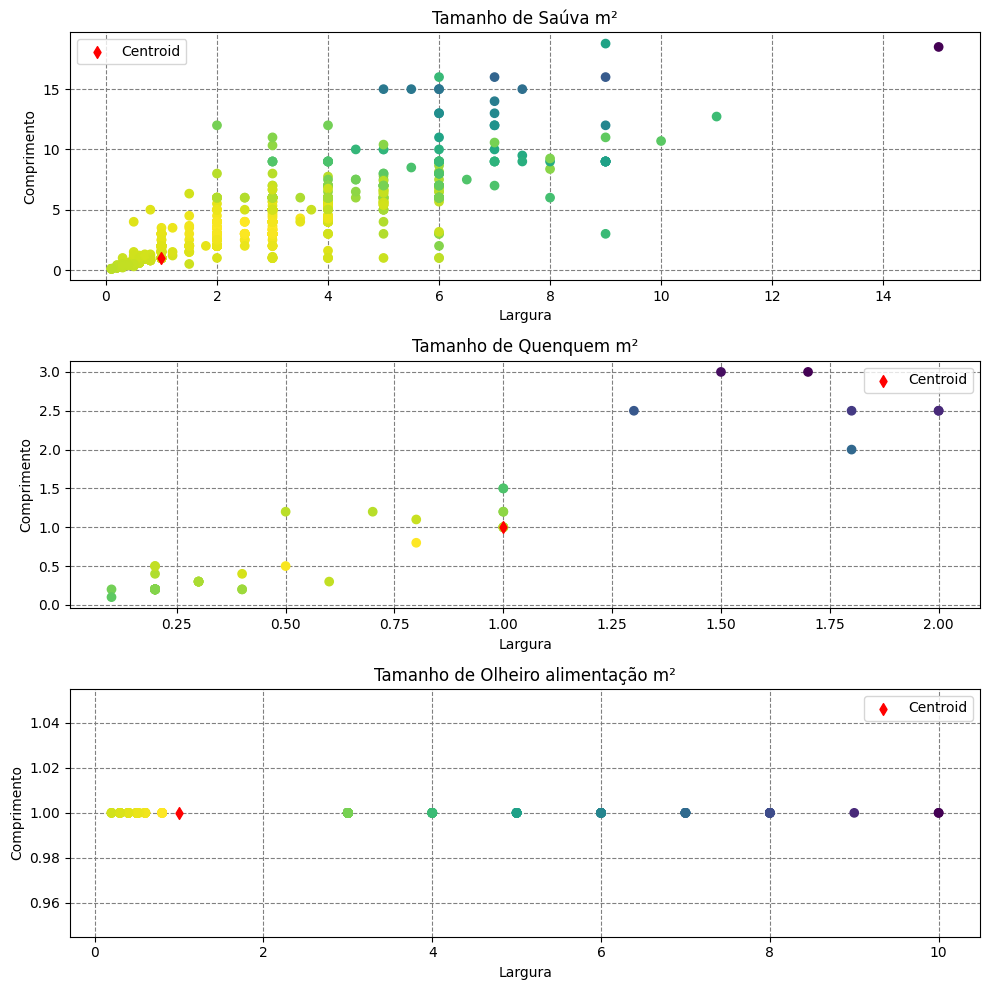

In [389]:
if num_charts == 1: num_charts+=1
fig, ax = plt.subplots(num_charts)
fig.set_size_inches(10, 10)

for index, grupo in enumerate(unique_grupo):


    dataset_filter = dataset.loc[dataset['ID_GRUPO'] == grupo]

    ax[index].set_axisbelow(True)

    ax[index].set_xlabel('Largura')
    ax[index].set_ylabel('Comprimento')

    ax[index].grid(linestyle='dashed', color='gray')

    ax[index].scatter(
        x=dataset_filter['VL_LARG'],
        y=dataset_filter['VL_COMP_2'],
        c=dataset_filter['DISTANCE_CENTROID'],
        cmap="viridis_r",
        alpha=1)
        
    c = ax[index].scatter(coordinatesCenter[0], coordinatesCenter[1], color='red', marker="d", label="Centroid", alpha=1)

    ax[index].set_title(f"Tamanho de {nome_grupo[grupo]} m²")
    
    ax[index].legend(handles=[c],scatterpoints=1)

    fig.tight_layout()

plt.savefig(f'mining.pdf', dpi=300)